## MLE computation

compute the MLE to check quality of estimates and code functionality.

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [5]:
# set some random system parameters

a_true = 1.1
n0_true = 2.3
noise = 1.0
M = 100

hprm = Src.Hyperprm(0.95, n0_true, a_true, 0.45, M, noise)

Main.Src.Hyperprm(0.95, 2.3, 1.1, 0.45, 100, 1.0)

In [6]:
# generate true data, i.e. data observations

sol_true = Src.sol_klausmeier(hprm; t_fixed=true, t_end=100.0) 
sol_true = Src.randomize_data(sol_true, hprm.noise); # make data noisy


In [16]:
# compute MLE

if noise == 0.0 # in this case stick to true prm combination
    mle, success = [a_true, n0_true], true
else
    mle, success = Src.compute_mle(hprm, sol_true; t_fixed=true, t_end=100.0) # compute MLE
end

print("[a_mle, n0_mle] = $mle")

[a_mle, n0_mle] = [1.1266421140005822, 2.5475095693804075]

In [ ]:
# compute Fi evaluated at MLE and at true prm point
# compare both and see that Fi differs. Note that fi_mle not necessarily higher than fi_true

fi_mle = Src.compute_fi(mle, hprm, sol_true; t_fixed=true, t_end=500.0)
fi_true = Src.compute_fi([a_true,n0_true], hprm, sol_true; t_fixed=true, t_end=500.0)

print("fi_mle, fi_true = $fi_mle, $fi_true")

fi_mle, fi_true = 873.3595816195476, 955.2826251151197

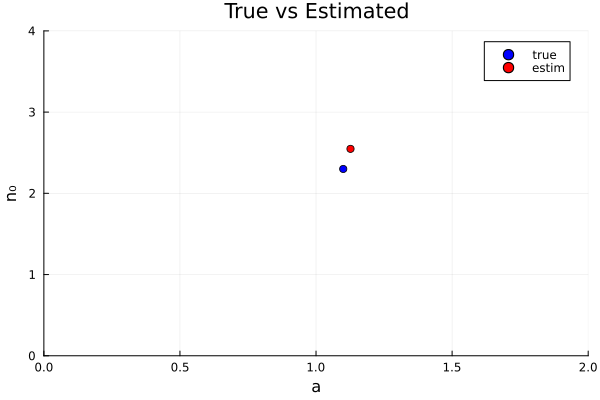

In [18]:
# plot true prm vs MLE

using Plots
scatter([a_true], [n0_true], label = "true", color = :blue,xlabel = "a", ylabel = "n₀",xlims = (0, 2), ylims = (0, 4),legend = :topright,title = "True vs Estimated")
scatter!([mle[1]], [mle[2]], label = "estim", color = :red)

I checked the corresponding log-likelihood plots for different points and noise levels and the MLEs visually fit the maxima of the respective log-likelihood functions.